In [2]:
import numpy as np
import theano
import theano.tensor as T
import pandas as pd
from theano.tensor.nnet.bn import batch_normalization_train, batch_normalization_test
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./train.csv')

In [4]:
# Load data

data = df.values.astype(np.float32)
np.random.shuffle(data)
X = data[:, 1:]
Y = data[:, 0]

Xtrain = X[:-1000]
Ytrain = Y[:-1000]
Xtest  = X[-1000:]
Ytest  = Y[-1000:]

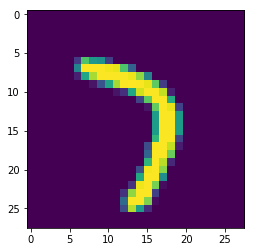

In [5]:
s = np.reshape(Xtrain[0], (28, 28))
plt.imshow(s)
plt.show()

In [6]:
# normalizie the data

mu = Xtrain.mean(axis=0)
std = Xtrain.std(axis=0)

np.place(std, std == 0, 1)

Xtrain = (Xtrain - mu) / std
Xtest = (Xtest - mu) / std

In [7]:
# change y to hot encoder

def y2indicator(y):

    y = y.astype(np.int32)
    ind = np.zeros((len(y), 10))

    for i in range(len(y)):
        ind[i, y[i]] = 1
        
    return ind

In [8]:
def error_rate(p, t):
    return np.mean(p != t)

In [9]:
def relu(a):
    return a * (a > 0)

In [10]:
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

In [11]:
# data is ready

Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)
Ytrain = Ytrain.astype(np.float32)
Ytest = Ytest.astype(np.float32)
Ytrain_ind = Ytrain_ind.astype(np.float32)
Ytest_ind = Ytest_ind.astype(np.float32)

In [12]:
# initial values

max_iter = 15
print_period = 100

lr = 0.0004
reg = 0.01 #smooth parameter

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

M = 300
K = 10

In [13]:
W1_init = np.random.randn(D, M) / 28
b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
b2_init = np.zeros(K)

In [14]:
# step 2: define theano variables and expressions
thX = T.matrix('X')
thT = T.matrix('T')
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')

In [15]:
gamma1_init = np.ones(M)
beta1_init = np.zeros(M)
gamma2_init = np.ones(K)
beta2_init = np.zeros(K)


gamma1 = theano.shared(gamma1_init, 'gamma1')
beta1 = theano.shared(beta1_init, 'beta1')
gamma2 = theano.shared(gamma2_init, 'gamma2')
beta2 = theano.shared(beta2_init, 'beta2')

In [16]:
running_mean1_init = np.zeros(M)
running_var1_init = np.zeros(M)
running_mean2_init = np.zeros(K)
running_var2_init = np.zeros(K)

running_mean1 = theano.shared(running_mean1_init)
running_var1 = theano.shared(running_var1_init)
running_mean2 = theano.shared(running_mean2_init)
running_var2 = theano.shared(running_var2_init)

In [17]:
#define training model
thA1 = thX.dot(W1) 
thA1_prime, batch_mean1, batch_invstd1, new_running_mean1, new_running_var1 = batch_normalization_train(
        thA1, gamma1, beta1, running_mean=running_mean1, running_var=running_var1)
thZ1 = relu(thA1_prime)

thA2 = thZ1.dot(W2)
thA2_prime, batch_mean2, batch_invstd2, new_running_mean2, new_running_var2 = batch_normalization_train(
        thA2, gamma2, beta2, running_mean=running_mean2, running_var=running_var2)
thY = T.nnet.softmax(thA2_prime)

# theano.tensor.nnet.bn.batch_normalization_train(inputs, gamma, beta, axes='per-activation', epsilon=0.0001,
#                                                  running_average_factor=0.1, running_mean=None, running_var=None)

#running_average_factor is 1 - decay
#batch_var = 1 / (batch_invstd * batch_invstd)
# new_running_mean = decay * running_mean + (1-decay) * batch_mean
# new_running_var = decay * running_var + (1-decay) * batch_var

#out (tensor) – Batch-normalized inputs.
#mean (tensor) – Means of inputs across the normalization axes.
#invstd (tensor) – Inverse standard deviations of inputs across the normalization axes.
#new_running_mean (tensor) – New value of the running mean (only if both running_mean and running_var were given).
#new_running_var (tensor) – New value of the running variance (only if both running_var and running_mean were given).

In [18]:
#define test model
thA1_test = thX.dot(W1) 
thA1_test_prime = batch_normalization_test(thA1_test, gamma1, beta1, running_mean1, running_var1)
thZ1_test = relu(thA1_test_prime)

thA2_test = thZ1_test.dot(W2)
thA2_test_prime = batch_normalization_test(thA2_test, gamma2, beta2, running_mean2, running_var2)
thY_test = T.nnet.softmax(thA2_test_prime)

In [20]:
cost = -(thT * T.log(thY)).sum()
prediction_test = T.argmax(thY_test, axis = 1)

In [21]:
update_W1 = W1 - lr*T.grad(cost, W1)
#update_b1 = b1 - lr*T.grad(cost, b1)
update_W2 = W2 - lr*T.grad(cost, W2)
#update_b2 = b2 - lr*T.grad(cost, b2)

update_gamma1 = gamma1 - lr*T.grad(cost, gamma1)
update_beta1 = beta1 - lr*T.grad(cost, beta1)
update_gamma2 = gamma2 - lr*T.grad(cost, gamma2)
update_beta2 = beta2 - lr*T.grad(cost, beta2)

updates = [(W1, update_W1), (W2, update_W2)] + [(gamma1, update_gamma1), (beta1, update_beta1), (gamma2, update_gamma2), (beta2, update_beta2)]+ [(running_mean1, new_running_mean1), (running_mean2, new_running_mean2)]

In [22]:
train = theano.function(inputs=[thX, thT], updates = updates)

In [26]:
get_prediction = theano.function(inputs=[thX, thT], outputs=[cost, prediction_test])

Cost / err at iteration i=0, j=0, cost_value: 1542.009, error: 0.463
Cost / err at iteration i=1, j=0, cost_value: 335.071, error: 0.095
Cost / err at iteration i=2, j=0, cost_value: 228.037, error: 0.089
Cost / err at iteration i=3, j=0, cost_value: 192.311, error: 0.089
Cost / err at iteration i=4, j=0, cost_value: 170.688, error: 0.090
Cost / err at iteration i=5, j=0, cost_value: 160.319, error: 0.102
Cost / err at iteration i=6, j=0, cost_value: 167.721, error: 0.106
Cost / err at iteration i=7, j=0, cost_value: 155.669, error: 0.109
Cost / err at iteration i=8, j=0, cost_value: 164.248, error: 0.106
Cost / err at iteration i=9, j=0, cost_value: 170.029, error: 0.115
Cost / err at iteration i=10, j=0, cost_value: 134.619, error: 0.115
Cost / err at iteration i=11, j=0, cost_value: 127.100, error: 0.121
Cost / err at iteration i=12, j=0, cost_value: 126.049, error: 0.116
Cost / err at iteration i=13, j=0, cost_value: 139.822, error: 0.119
Cost / err at iteration i=14, j=0, cost_val

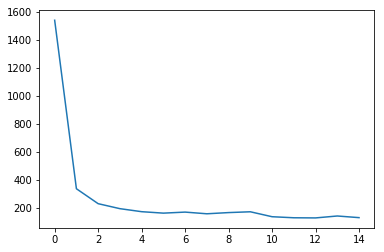

In [27]:
costs = []
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            print("Cost / err at iteration i=%d, j=%d, cost_value: %.3f, error: %.3f" % (i, j, cost_val, err))
            costs.append(cost_val)

plt.plot(costs)
plt.show()